This code is prepared to implement K-fold cross validation on Naive Bayes model.
Basically I applied K-fold method over different alpha values and compared their accuracies(10-fold avarage) and found out the optimum alpha which gives us the best accuracy.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# spam classifier which will be used for K-fold cross validation in the next cell
class SpamClassifier:
    def __init__(self, k):
        self.k = k
        self.log_class_priors = 0
        self.log_class_conditional_likelihoods = 0
        
    # main function for training
    def train(self, alpha):
        # inner function to create class priors
        def estimate_log_class_priors(data):
            # filter out our class labeled data "y"  which is in the first column
            y = data[:,0]
            
            # create two arrays for two classes (num_C0:ham messages and num_C1:spam messages) 
            num_C0 = np.count_nonzero(y == 0)
            num_C1 = np.count_nonzero(y == 1)
            
            # find the probability of class priors and take their logarithms
            # P(C=0) -- class_priors_C0, P(C=1) -- class_priors_C1
            class_priors_C0 = np.log(num_C0/(num_C0 + num_C1))
            class_priors_C1 = np.log(1 - num_C0/(num_C0 + num_C1))
            
            # create an array including all class priors with length two
            log_class_priors = np.array([class_priors_C0, class_priors_C1])

            return log_class_priors
        
        # inner function to create class conditional likelihoods
        def estimate_log_class_conditional_likelihoods(data, alpha):
            # filter out our class labeled data "y" which is in the first column
            # and create our input data
            y = data[:,0]            
            input_data = data[:, 1:]
            
            # detect the number of words and assign this to self.k
            #self.k = len(data[0, 1:])
                
            # get row indices of each classes (0-ham & 1-spam msg) within our data
            indices_C0 = np.nonzero(y == 0)
            indices_C1 = np.nonzero(y == 1) 
            
            # create our data for each classes (data_C0:ham messages and data_C1:spam messages)
            data_C0 = input_data[indices_C0]
            data_C1 = input_data[indices_C1]
            
            # calculate the frequency of each message for each of the classes
            # within the whole training set
            num_of_w_class0 = np.count_nonzero(data_C0 == 1, axis=0)
            num_of_w_class1 = np.count_nonzero(data_C1 == 1, axis=0)
            
            # create an array for each class, that includes the probabilities of each keyword 
            # drawn from a bag of words and concatenate them into one array(theta)
            prob_array_0 = np.log((num_of_w_class0 + alpha) / ((sum(num_of_w_class0) + self.k*alpha)))
            prob_array_1 = np.log((num_of_w_class1 + alpha) / ((sum(num_of_w_class1) + self.k*alpha)))
            theta = np.concatenate(([prob_array_0], [prob_array_1]), axis=0)
            
            return theta
        
        self.log_class_priors = estimate_log_class_priors(training_data)
        self.log_class_conditional_likelihoods = estimate_log_class_conditional_likelihoods(training_data, alpha)
        
    def predict(self, new_data):     
        prediction_matrix = 0
        # matrix product of new_data and the transpose of log_class_conditional_likelihoods (∑ 𝑤i * log(𝜃𝑐,𝑤𝑖))
        # by doing this matrix product we can greatly decrease the complexity of computation
        pre_prediction_matrix = new_data@self.log_class_conditional_likelihoods.T

        # Here we add P(C=c) to the above matrix so that we calculate the predictions of n_test_samples for 2 classes
        prediction_matrix = np.array([pre_prediction_matrix[:, 0] + self.log_class_priors[0], \
                                      pre_prediction_matrix[:, 1] + self.log_class_priors[1]])

        class_predictions = np.where(prediction_matrix[1, :] > prediction_matrix[0, :], 1, 0)
        return class_predictions    

def create_classifier(alpha):
    classifier = SpamClassifier(k=54)
    classifier.train(alpha)
    return classifier

K-fold Max-Avg. Accuracy : 0.917 
Alpha Chosen : 274
Accuracy on training data is: 0.917
Accuracy on testing data is: 0.902


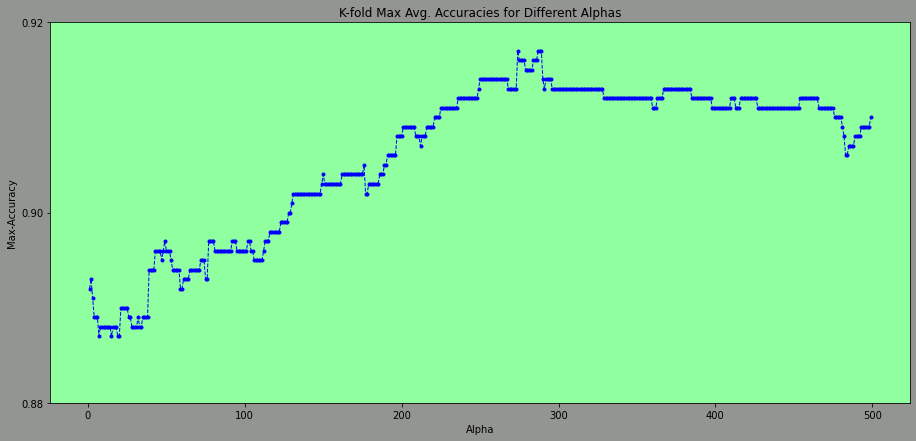

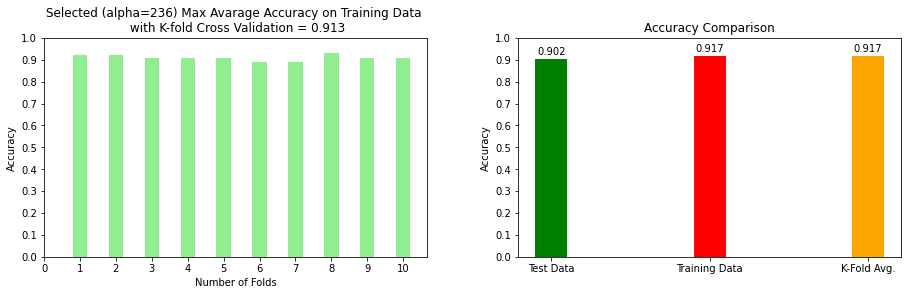

In [6]:
# k-fold cross-validation to chose alpha

# load files and shuffle the instances
full_spam = np.loadtxt(open("data/training_spam.csv"), delimiter=",").astype(np.int)
test_spam = np.loadtxt(open("data/testing_spam.csv"), delimiter=",").astype(np.int)
np.random.seed(10)
np.random.shuffle(full_spam)
np.random.shuffle(test_spam)

# k-fold cross validation algorithm for different alphas
array_total_accuracy = []
max_avg_accuracy = 0
opt_alpha = 0
for alpha in range(1, 500):
    fold = 10
    total_accuracy = 0
    avg_accuracy = 0
    fold_array = []
    for i in range(1, fold+1):
        test_data = full_spam[100*(i-1):100*(i), 1:]
        test_labels = full_spam[100*(i-1):100*(i), 0]
        #training_data = np.concatenate((full_spam[:100*(i-1), :], full_spam[100*i:, :]), axis=0)

        classifier = create_classifier(alpha)

        predictions = classifier.predict(test_data)
        accuracy = np.count_nonzero(predictions == test_labels)/test_labels.shape[0]
        total_accuracy += round(accuracy, 3)
        fold_array.append(round(accuracy, 3))
    avg_accuracy = round(total_accuracy/fold, 3)
    array_total_accuracy.append(avg_accuracy)    
    if avg_accuracy > max_avg_accuracy:
        max_avg_accuracy = avg_accuracy
        opt_alpha = alpha
        
# print the best avarage accuracy and associated alpha from different k-folds
print("K-fold Max-Avg. Accuracy :", round(max_avg_accuracy, 3), "\n" "Alpha Chosen :", opt_alpha)

# calculate accuracy on test data
training_data = full_spam
test_labels = full_spam[:, 0]
test_data = full_spam[:, 1:]
classifier = create_classifier(opt_alpha)
predictions = classifier.predict(test_data)
accuracy1 = np.count_nonzero(predictions == test_labels)/test_labels.shape[0]
print(f"Accuracy on training data is: {round(accuracy1, 3)}")

# calculate accuracy on training data
training_data = full_spam
test_labels = test_spam[:, 0]
test_data = test_spam[:, 1:]
classifier = create_classifier(opt_alpha)
predictions = classifier.predict(test_data)
accuracy2 = np.count_nonzero(predictions == test_labels)/test_labels.shape[0]
print(f"Accuracy on testing data is: {round(accuracy2, 3)}")

# graphic representation part
fig, ax = plt.subplots(figsize=(15.4, 7))
fig.patch.set_facecolor('xkcd:grey')
ax.set_facecolor('xkcd:mint green')

# k-fold avg. accuracy vs alpha graph
graph1 = ax.plot(range(1, 500), array_total_accuracy, 'bo', linewidth=1, markersize=3, linestyle='dashed')
ax.set_ylabel("Max-Accuracy")
ax.set_xlabel("Alpha")
ax.set_yticks(np.arange(0.88, 0.94, 0.02))
ax.set_title("K-fold Max Avg. Accuracies for Different Alphas")

# k-fold with best alpha and accuracy comparison
fig = plt.figure(figsize=(14, 5))
plt1 = fig.add_subplot(121)
plt2 = fig.add_subplot(122)
fig.tight_layout(pad=6)

plt1.bar([1,2,3,4,5,6,7,8,9,10], fold_array, color = 'lightgreen', width = 0.4)
plt1.set(title=("Selected (alpha=236) Max Avarage Accuracy on Training Data \n with K-fold Cross Validation = 0.913"))
plt1.set(xlabel=("Number of Folds"), ylabel="Accuracy")
plt1.set_yticks(np.arange(0, 1.1, 0.1))
plt1.set_xticks(np.arange(0,11))

plt2.bar(["Test Data", "Training Data", "K-Fold Avg."], [accuracy2, accuracy1, max_avg_accuracy], color = ['green','red','orange'], width = 0.2)
plt2.set(ylabel="Accuracy")
plt2.set_title('Accuracy Comparison')
plt2.set_yticks(np.arange(0, 1.1, 0.1))
for index, value in enumerate([accuracy2, accuracy1, max_avg_accuracy]):
    plt.text(index-.09, value+0.02, str(value))    
